# Data Engineering
This notebook steps through a Data Engineering exercise that joins several FHIR resources and converts them at scale into a timeseries-like data model. This notebook should be run after the getting_started notebook. 

First let's import some needed methods and create our Spark session.

In [4]:
from pyspark.sql.functions import col, lit

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt

from pyspark.sql import SparkSession

# Create a Spark session that uses local execution, warehouse, and metadata,
# with Hive support to save to tables.
spark = SparkSession.builder \
                    .config('hive.exec.dynamic.partition.mode', 'nonstrict') \
                    .enableHiveSupport() \
                    .getOrCreate()

Now we will make sure the imported data exists:

note: I had an issue here because of 2 running spark shell instances - solution: get the pid and kill older one

In [10]:
! ps -ef | grep spark-shell

jovyan     875   855  2 10:13 ?        00:00:18 /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java -cp /usr/local/spark/conf/:/usr/local/spark/jars/* -Xmx1g org.apache.spark.deploy.SparkSubmit --conf spark.sql.catalogImplementation=hive --conf hive.exec.dynamic.partition.mode=nonstrict --jars /usr/local/bunsen/jars/bunsen-shaded-0.4.3.jar pyspark-shell
jovyan     997   855 38 10:28 pts/0    00:00:00 /bin/sh -c  ps -ef | grep spark-shell
jovyan     999   997  0 10:28 pts/0    00:00:00 grep spark-shell


In [9]:
! kill -9 49

In [11]:
spark.sql('use tutorial_small')
spark.sql('show tables').toPandas()

,database,tableName,isTemporary
0,tutorial_small,allergyintolerance,False
1,tutorial_small,careplan,False
2,tutorial_small,claim,False
3,tutorial_small,condition,False
4,tutorial_small,encounter,False
5,tutorial_small,immunization,False
6,tutorial_small,medication,False
7,tutorial_small,medicationrequest,False
8,tutorial_small,observation,False
9,tutorial_small,organization,False


# Valuesets
Common code systems or valuesets, such as those [defined by the VSAC](https://vsac.nlm.nih.gov/valuesets) can be used in the cluster. Here we mostly use user-provided constants to keep the example simple.

In [12]:
from bunsen.stu3.valuesets import push_valuesets, valueset

# Typically these would the isa_loinc or isa_snomed functions, but
# we didn't want the tutorial to require downloading those ontologies.
push_valuesets(spark, 
               {'ldl'               : [('http://loinc.org', '18262-6')],                
                'hdl'               : [('http://loinc.org', '2085-9')],
                'triglycerides'     : [('http://loinc.org', '2571-8')],
                'hba1c'             : [('http://loinc.org', '4548-4')], 
                'chd'               : [('http://snomed.info/sct', '53741008')],
                'hypertension'      : [('http://snomed.info/sct', '38341003')],
                'mi'                : [('http://snomed.info/sct', '22298006')], 
                # The following were loaded in the getting started notebook.
                'diabetes_risks'    : valueset('http://engineering.cerner.com/bunsen/example', '201806001'),                
                'example'           : valueset('http://hl7.org/fhir/ValueSet/example-extensional', '20150622')},
               database='tutorial_ontologies');   

# Projected onto simple tables
As seen in the Getting Started notebook, we can interactively query FHIR datasets and project them onto simple tables. Notice the use of the in_valueset UDF that references the valueset names seen above.

In [14]:
spark.table('condition').printSchema()

root
 |-- id: string (nullable = true)
 |-- meta: struct (nullable = true)
 |    |-- id: string (nullable = true)
 |    |-- versionId: string (nullable = true)
 |    |-- lastUpdated: timestamp (nullable = true)
 |    |-- profile: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- security: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- id: string (nullable = true)
 |    |    |    |-- system: string (nullable = true)
 |    |    |    |-- version: string (nullable = true)
 |    |    |    |-- code: string (nullable = true)
 |    |    |    |-- display: string (nullable = true)
 |    |    |    |-- userSelected: boolean (nullable = true)
 |    |-- tag: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- id: string (nullable = true)
 |    |    |    |-- system: string (nullable = true)
 |    |    |    |-- version: string (nullable = true)
 |    |    |    |-- code: s

In [13]:
spark.sql("""
select subject.reference,
       code.coding[0].system system, 
       code.coding[0].code code,
       onsetDateTime
from condition
where in_valueset(code, 'chd')
""").limit(10).toPandas()

,reference,system,code,onsetDateTime
0,urn:uuid:17c10896-7229-45af-ba70-6975eb174a43,http://snomed.info/sct,53741008,2011-12-19T03:37:12-06:00
1,urn:uuid:62ee59e7-9de4-4f3d-8f60-567190b46ba5,http://snomed.info/sct,53741008,1998-06-24T00:22:33-05:00
2,urn:uuid:e9d63d0e-b04f-414c-9989-4f497c12e5cc,http://snomed.info/sct,53741008,2014-12-03T16:01:35-06:00
3,urn:uuid:980bde8d-0b10-400b-84ae-b72d86939fbf,http://snomed.info/sct,53741008,2002-05-13T17:44:28-05:00
4,urn:uuid:9dee7b08-edad-44af-ae29-c05d144fb757,http://snomed.info/sct,53741008,1997-01-13T19:01:03-06:00
5,urn:uuid:7986e7d7-f2e4-4d1a-92b1-d3c92b625c9f,http://snomed.info/sct,53741008,2006-03-01T17:48:17-06:00
6,urn:uuid:cbd0071f-d976-479b-b008-e1d28d91c533,http://snomed.info/sct,53741008,2015-06-02T06:12:48-05:00
7,urn:uuid:725173de-8806-4985-94f3-b0fb77aafeb4,http://snomed.info/sct,53741008,2001-09-27T15:09:34-05:00
8,urn:uuid:3438ea8c-cc22-4612-9f2a-5ee2262da974,http://snomed.info/sct,53741008,2001-09-08T18:48:25-05:00
9,urn:uuid:00d3a53e-0b83-4769-b010-4e23f5db8987,http://snomed.info/sct,53741008,2009-03-28T12:13:51-05:00


A similar example for the [FHIR Observation Model](https://www.hl7.org/fhir/observation.html). 

In [15]:
ldl_values = spark.sql("""
select subject.reference, 
       code.coding[0].code code,
       valueQuantity.value,
       effectiveDateTime
from observation 
where in_valueset(code, 'ldl') and year(effectiveDateTime) = 2017
""")

ldl_values.limit(10).toPandas()

,reference,code,value,effectiveDateTime
0,urn:uuid:e9d63d0e-b04f-414c-9989-4f497c12e5cc,18262-6,75.4863,2017-12-20T16:01:35-06:00
1,urn:uuid:cbd0071f-d976-479b-b008-e1d28d91c533,18262-6,143.4196,2017-01-17T05:12:48-06:00
2,urn:uuid:cbd0071f-d976-479b-b008-e1d28d91c533,18262-6,141.3666,2017-02-21T05:12:48-06:00
3,urn:uuid:cbd0071f-d976-479b-b008-e1d28d91c533,18262-6,122.5672,2017-03-21T06:12:48-05:00
4,urn:uuid:cbd0071f-d976-479b-b008-e1d28d91c533,18262-6,127.1894,2017-04-18T06:12:48-05:00
5,urn:uuid:cbd0071f-d976-479b-b008-e1d28d91c533,18262-6,121.9720,2017-05-16T06:12:48-05:00
6,urn:uuid:cbd0071f-d976-479b-b008-e1d28d91c533,18262-6,143.6122,2017-06-20T06:12:48-05:00
7,urn:uuid:cbd0071f-d976-479b-b008-e1d28d91c533,18262-6,123.2975,2017-07-18T06:12:48-05:00
8,urn:uuid:cbd0071f-d976-479b-b008-e1d28d91c533,18262-6,144.9078,2017-08-15T06:12:48-05:00
9,urn:uuid:cbd0071f-d976-479b-b008-e1d28d91c533,18262-6,130.9980,2017-09-19T06:12:48-05:00


## Data analysis
Now that we have data in a tabular format, we can easily calculate summary statistics or plot its distribution. (Of course, in a real system the counts would be much higher, and the distribution much smoother.)

In [16]:
ldl_values.describe().toPandas()

,summary,reference,code,value,effectiveDateTime
0,count,62,62,62,62
1,mean,None,None,111.52852903,None
2,stddev,None,None,30.612884121507538,None
3,min,urn:uuid:00d3a53e-0b83-4769-b010-4e23f5db8987,18262-6,57.6543,2017-01-11T07:33:23-06:00
4,max,urn:uuid:fd8e392e-661c-41de-aae9-b344fc2c1a9f,18262-6,182.9637,2017-12-27T17:29:37-06:00


charting the values of ldl distribution

Text(0.5,0,'value')

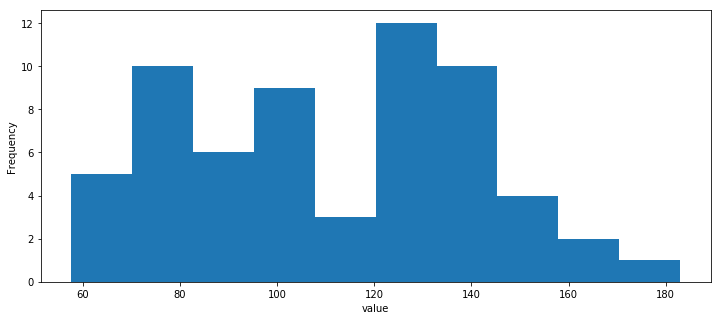

In [17]:
ldl_values.select(col('value').cast('float')) \
          .toPandas() \
          .plot(kind='hist', 
                bins=10, 
                figsize=(12,5), 
                legend=False) \
          .set_xlabel("value")

## Building Cohorts
Let's track down a group of people we want to analyze. In this case, we're interested in people:

* With at least one of the following:
 * A diabetes condition
 * A pre-diabetes condition
 * An elevated HbA1c value 
* And who haven't had a wellnes visit in some time

We can achieve this by simple creating dataframes with the desired subset of people. In this example, we have "diabetes_risks" valueset that contains diabetes-related conditions, so we just query it:

In [ ]:
diabetes_conditions = spark.sql("""
select id condition_id, 
       subject.reference person_ref, 
       coding.system,
       coding.code,
       coding.display
from condition 
     lateral view explode(code.coding) nested as coding
where in_valueset(code, 'diabetes_risks')
""")

diabetes_conditions.limit(10).toPandas()

Note that we can add further qualifications or explore the entire dataset interactively to make sure our query is producing the expected results.

Now let's find people with a high hba1c:

In [ ]:
high_hba1c = spark.sql("""
select id observation_id,
       subject.reference person_ref,
       valueQuantity.value,
       valueQuantity.unit
from observation 
     lateral view explode(code.coding) nested as coding
where in_valueset(code, 'hba1c') and
      valueQuantity.value >= 6.5 and
      status = 'final'
""")

high_hba1c.limit(10).toPandas()

Now we can just select the person IDs from both of the above dataframes and union them to get our complete list of people who are at risk:

In [ ]:
diabetes_risk = high_hba1c.select('person_ref') \
                          .union(diabetes_conditions.select('person_ref')) \
                          .distinct()
        
diabetes_risk.limit(10).toPandas()

Now let's find all of the wellness visits in the last couple years, which we use to exclude people from our cohort:

In [ ]:
wellness_visits = spark.sql("""
select subject.reference person_ref, 
       period.start encounter_start,
       period.end encounter_start
from encounter 
where class.code = 'WELLNESS' and
      period.start > '2016'
""")

wellness_visits.limit(10).toPandas()

Finally, to exclude people who have had wellness visits, we will do an anti-join between our at-risk group and the visits dataframe we created. The end result is a simple table with the required people!

In [ ]:
diabetes_without_wellness = diabetes_risk.join(wellness_visits, 
                                               ['person_ref'], 
                                               'left_anti')

diabetes_without_wellness.limit(10).toPandas()

## Building a Time Series
We've looked at some general queries, but a number of machine learning and other analysis works best if we can create a time series from our data. We'll start with some (arbitrary) observation values by month.

Except for the *in_valueset* method, all of this is standard SQL, leverage Apache Spark's support of nested structures. The "group by" clause defines the time periods to aggregate by, and aggregation functions like *avg* or *max* will conditionally include values that satisfy the nested *if* expression.

Advanced SQL users can also leverage window functions over this data. See the Spark documentation for details.

In [ ]:
observations = spark.sql("""
select subject.reference patient_id,
       year(effectiveDateTime) year,
       month(effectiveDateTime) month,
       
       avg(if(in_valueset(code, 'hba1c'), 
              valueQuantity.value, 
              null)) avg_hba1c_level,       

       avg(if(in_valueset(code, 'ldl'), 
              valueQuantity.value, 
              null)) avg_ldl,

       avg(if(in_valueset(code, 'hdl'), 
              valueQuantity.value, 
              null)) avg_hdl,
                                          
       max(if(in_valueset(code, 'triglycerides'), 
              valueQuantity.value, 
              null)) max_triglycerides
              
from observation
where effectiveDateTime >= '2013-01-01' and
      effectiveDateTime < '2018-01-01'
group by subject.reference, 
         year(effectiveDateTime), 
         month(effectiveDateTime)
order by patient_id, year, month 
""").cache()

In [ ]:
observations.limit(10).toPandas()

Here is a similar aggregation for conditions. We can include an arbitrary number of FHIR resources using this pattern.

In [ ]:
conditions = spark.sql("""
select subject.reference patient_id,
       year(onsetDateTime) year,
       month(onsetDateTime) month,

       max(if(in_valueset(code, 'hypertension'), 
              true, 
              false)) hypertension,
              
       max(if(in_valueset(code, 'mi'), 
              true, 
              false)) mi,
              
       max(if(in_valueset(code, 'chd'), 
              true, 
              false)) chd             
              
from condition
where onsetDateTime >= '2013-01-01' and
      onsetDateTime < '2018-01-01'
group by subject.reference, 
         year(onsetDateTime), 
         month(onsetDateTime)
order by patient_id, year, month         
""").cache()

Finally, we grab some demographics data about hte patient and join it to the observations and conditions data frames loaded above.

In [ ]:
patients = spark.sql("""
select id patient_id, birthDate from patient
""")

In [ ]:
joined_patient = patients \
                 .join(observations, 'patient_id', 'left_outer') \
                 .join(conditions, ['patient_id', 'year', 'month'], 'left_outer') \
                 .where(col('year').isNotNull())

That's it! Let's take a look at our handiwork:

In [ ]:
joined_patient.limit(10).toPandas()

## Save to a table 
Now we will save the results of our engineering exercise to a table for others to use. This may be handing off our dataset to an analyst or data scientist for a specific use case, or just keeping a copy for ourselves so we don't need to reproduce it in the future.

In [ ]:
spark.sql('create database if not exists my_analysis_work')

# Only needed so this notebook can be run repeatedly
spark.sql('drop table if exists my_analysis_work.example_timeseries')

joined_patient.write.saveAsTable('my_analysis_work.example_timeseries')

Now we can query the table we just saved and see the expected results:

In [ ]:
spark.sql('select * from my_analysis_work.example_timeseries limit 10').toPandas()

## What's Next?
Such a simple, tabular model suited for our use case is easily consumed for a variety of analysis. Let's take a look at a few:

### Descriptive Statistics
Machine Learning gets all of the attention, but a lot of problems can be solved with descriptive statistics. Fortunately Apache Spark offers a rich package for this. Here's a single line to compute the correlation between LDL and triglycerides in our dataset:

In [ ]:
joined_patient.corr('avg_ldl', 'max_triglycerides')

### Windowing Functions
Spark [Windowing Functions](https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html) can be easily used with this format to simplify making predictions about future state. 

Here we simplly add a column indicating whether the next time slot for a patient has a Coronary Heart Disease diagnosis:

In [ ]:
from pyspark.sql.window import Window
import pyspark.sql.functions as func

window = Window.partitionBy('patient_id').orderBy('year', 'month')

predict_chd = joined_patient.withColumn('next_chd', func.lead('chd').over(window))

predict_chd.limit(10).toPandas()

## SQL on FHIR

See the draft at [github.com/rbrush/sql-on-fhir](https://github.com/rbrush/sql-on-fhir/blob/master/sql-on-fhir.md). Many of these conventions are being added to Bunsen and other projects.



## Machine Learning
Finally, these data engineering tasks create a solid foundation for Machine Learning. We don't have time in this tutorial to go into depth here, but [Spark ML](https://spark.apache.org/docs/2.3.0/ml-pipeline.html) has a number of great references and will be very familiar to anyone familiar with Python's scikit-learn library. Users can also save our the tabular dataset and load it into any external ML tool that better fits their needs. 

```python
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# Predict CHD based on features extracted from the pipeline
regression = LogisticRegression(featuresCol='features', 
                                labelCol='next_chd',
                                maxIter=10)

# The pipeline contains several stages that extract and normalize features
# from our tabluar dataset
pipeline = Pipeline(stages=[convert_to_numeric, 
                            extract_lab_features,
                            scaled_lab_values,
                            assemble_feature_vector,
                            regression])

```
Now we can train the pipeline with the table we created above:

```python
# Split our table between training and test data
(train, test) = predict_chd.randomSplit([0.7, 0.3])

model = pipeline.fit(train)
```